In [ ]:
import umap
import joblib
import numpy as np
import cupy as cp
from google.colab import drive
from cuml import UMAP, KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 1. Load sparse TF-IDF matrix (on CPU)
X = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/tfidf_matrix_fast.pkl")

# 2. SVD on CPU (reduce to reasonable dimension)
n_components = 200
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd_cpu = svd.fit_transform(X)  # (n_samples, n_components), now dense numpy array

# 3. Remove all-zero rows (UMAP on GPU can't handle them)
row_norms = np.linalg.norm(X_svd_cpu, axis=1)
mask_nonzero = row_norms > 0
if not np.all(mask_nonzero):
    print(f"Removed {np.sum(~mask_nonzero)} all-zero vectors from SVD output.")
X_svd_cpu = X_svd_cpu[mask_nonzero]

# 4. Remove exact duplicate rows
X_svd_cpu_unique, unique_indices = np.unique(X_svd_cpu, axis=0, return_index=True)
if X_svd_cpu_unique.shape[0] != X_svd_cpu.shape[0]:
    print(f"Removed {X_svd_cpu.shape[0] - X_svd_cpu_unique.shape[0]} duplicate samples from SVD output.")

# 5. Copy to GPU (cupy)
import cupy as cp
X_svd_gpu = cp.asarray(X_svd_cpu_unique)

# 6. UMAP on GPU (RAPIDS cuML)
from cuml import UMAP
umap_reducer = UMAP(n_components=30, random_state=42, n_neighbors=10)
X_umap_gpu = umap_reducer.fit_transform(X_svd_gpu)

# 7. KMeans clustering on GPU
from cuml import KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels_gpu = kmeans.fit_predict(X_umap_gpu)
kmeans_labels = cp.asnumpy(kmeans_labels_gpu)

# 8. DBSCAN per KMeans cluster on GPU
from cuml import DBSCAN
final_labels = np.full(len(X_umap_gpu), -1)   # Initialize all labels as -1
for i in range(n_clusters):
    idx = (kmeans_labels == i)
    if np.sum(idx) == 0:
        continue
    subcluster_gpu = X_umap_gpu[idx]
    dbscan = DBSCAN(eps=2.0, min_samples=10)
    sub_labels_gpu = dbscan.fit_predict(subcluster_gpu)
    sub_labels = cp.asnumpy(sub_labels_gpu)  # Bring back to CPU

    for j, sub_label in enumerate(sub_labels):
        if sub_label >= 0:
            final_labels[np.where(idx)[0][j]] = i * 1000 + sub_label
        else:
            final_labels[np.where(idx)[0][j]] = -1

# 9. Save final labels
joblib.dump(final_labels, "/content/drive/MyDrive/MSE 641 Project Data/kmeans_dbscan_joint_labels.pkl")
print("KMeans + DBSCAN joint clustering complete. Labels saved to data/kmeans_dbscan_joint_labels.pkl")

# save cleaned UMAP results for future analysis
joblib.dump(cp.asnumpy(X_umap_gpu), "/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_30_cleaned.pkl")



Removed 617 all-zero vectors from SVD output.
Removed 2328 duplicate samples from SVD output.
[2025-07-20 19:51:14.858] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-07-20 19:51:58.880] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9320 -> 7924. Using the larger integer type might result in better performance
KMeans + DBSCAN joint clustering complete. Labels saved to data/kmeans_dbscan_joint_labels.pkl


['/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_30_cleaned.pkl']

In [ ]:
import joblib
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples

# 1. Load the clustering labels and (optionally) your feature matrix
labels = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/kmeans_dbscan_joint_labels.pkl")  # shape: (n_samples,)

# Example: Load your feature matrix (must correspond to the same samples, e.g. UMAP results)
# If you have your feature file (e.g., 'umap_matrix_30_cleaned.pkl'), load it as well:
X_embedded = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_30_cleaned.pkl")   # Adjust path/filename as needed

print(f"Labels shape: {labels.shape}, Feature matrix shape: {X_embedded.shape}")

# 2. Filter out noise (label = -1) for metrics that require at least 2 clusters
valid = labels >= 0
X_valid = X_embedded[valid]
labels_valid = labels[valid]

print(f"Valid samples for evaluation: {X_valid.shape[0]}")

# 3. Run clustering evaluation metrics
if len(np.unique(labels_valid)) > 1 and len(labels_valid) > 10:
    sil_score = silhouette_score(X_valid, labels_valid)
    ch_score = calinski_harabasz_score(X_valid, labels_valid)
    db_score = davies_bouldin_score(X_valid, labels_valid)
    print(f"Silhouette score:         {sil_score:.4f}  (higher is better, max 1.0)")
    print(f"Calinski-Harabasz score:  {ch_score:.2f}   (higher is better)")
    print(f"Davies-Bouldin score:     {db_score:.4f}  (lower is better, min 0)")

    # Per-sample silhouette scores (for further analysis)
    sample_sil = silhouette_samples(X_valid, labels_valid)
    print(f"Sample Silhouette (mean±std): {sample_sil.mean():.4f} ± {sample_sil.std():.4f}")
    print(f"First 10 Silhouette samples: {sample_sil[:10]}")
else:
    print("Not enough valid clusters/samples for evaluation.")


Labels shape: (281223,), Feature matrix shape: (281223, 30)
Valid samples for evaluation: 232924
Silhouette score:         0.0157  (higher is better, max 1.0)
Calinski-Harabasz score:  391.76   (higher is better)
Davies-Bouldin score:     0.4578  (lower is better, min 0)
Sample Silhouette (mean±std): 0.0157 ± 0.4124
First 10 Silhouette samples: [-0.04410065 -0.02718055  0.03273145 -0.1815193  -0.0802022   0.03259473
  0.04187142 -0.12248208  0.05249784 -0.07735822]


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


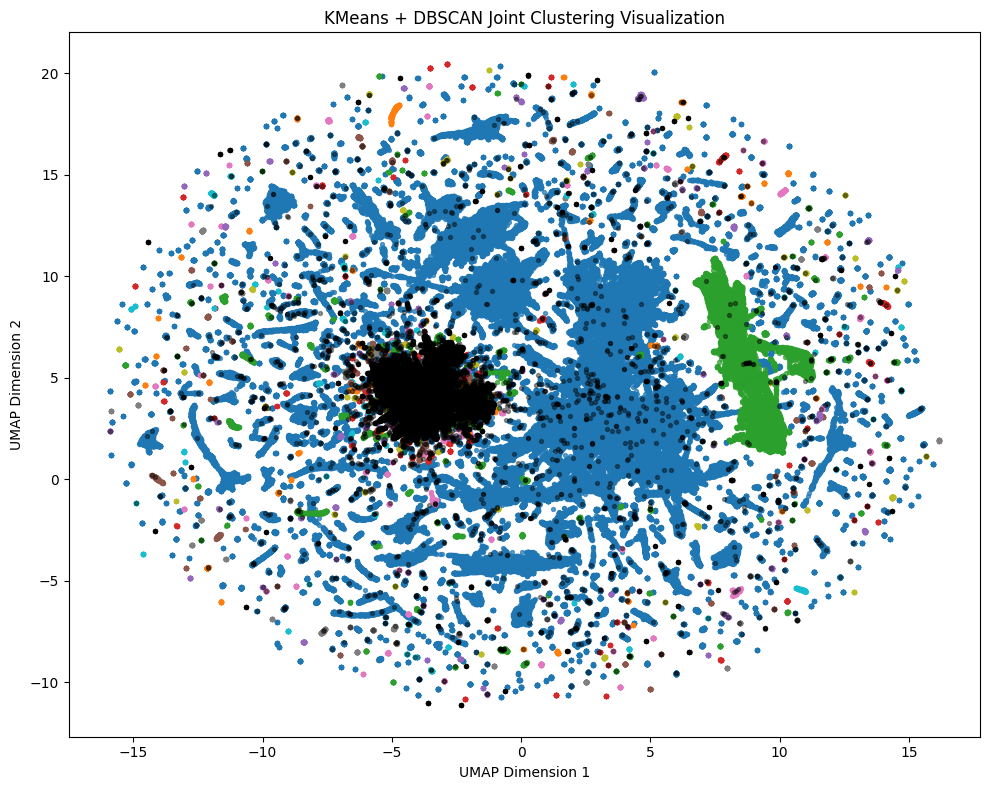

In [ ]:
import joblib
import numpy as np

# Load data (if not in memory)
X_umap = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_30_cleaned.pkl")    # shape = (n_samples, 30)
final_labels = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/kmeans_dbscan_joint_labels.pkl")

# If not already 2D, reduce to 2D for visualization
if X_umap.shape[1] > 2:
    import umap
    X_umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X_umap)
else:
    X_umap_2d = X_umap

import matplotlib.pyplot as plt

labels = final_labels
valid = labels >= 0    # Only valid clusters (ignore noise=-1)
unique_labels = np.unique(labels[valid])
num_clusters = len(unique_labels)

plt.figure(figsize=(10, 8))

# 用不同颜色显示不同簇
for cluster in unique_labels:
    mask = labels == cluster
    plt.scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1],
                s=8, label=f"Cluster {cluster}" if num_clusters<=12 else None, alpha=0.7)

# 标注噪声点
mask_noise = labels == -1
if mask_noise.any():
    plt.scatter(X_umap_2d[mask_noise, 0], X_umap_2d[mask_noise, 1],
                s=8, color="k", alpha=0.4, label="Noise")

plt.title("KMeans + DBSCAN Joint Clustering Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
if num_clusters<=12:
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import cupy as cp
from cuml import UMAP, KMeans

# --------- Load Data ---------
X = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/tfidf_matrix_fast.pkl")

# --------- SVD ---------
n_components = 200
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X)
row_norms = np.linalg.norm(X_svd, axis=1)
X_svd = X_svd[row_norms > 0]
X_svd, _ = np.unique(X_svd, axis=0, return_index=True)

# --------- UMAP ---------
umap_dim = 10
umap_n_neighbors = 5
X_gpu = cp.asarray(X_svd)
umap_model = UMAP(n_components=umap_dim, random_state=42, n_neighbors=umap_n_neighbors)
X_umap_gpu = umap_model.fit_transform(X_gpu)
X_umap = cp.asnumpy(X_umap_gpu)

# --------- KMeans ---------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_umap_gpu).get()

# --------- Metrics ---------
sil = silhouette_score(X_umap, labels)
ch = calinski_harabasz_score(X_umap, labels)
db = davies_bouldin_score(X_umap, labels)

print(f"UMAP(dim={umap_dim}, nn={umap_n_neighbors}) + KMeans(k={k}):")
print(f"Silhouette Score: {sil:.4f}")
print(f"Calinski-Harabasz Index: {ch:.1f}")
print(f"Davies-Bouldin Index: {db:.4f}")

# --------- Save Results ---------
joblib.dump(X_umap, "/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_dim10_nn5.pkl")
joblib.dump(labels, "/content/drive/MyDrive/MSE 641 Project Data/kmeans_labels_dim10_nn5_k5.pkl")


[2025-07-20 22:20:36.062] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP(dim=10, nn=5) + KMeans(k=5):
Silhouette Score: 0.7397
Calinski-Harabasz Index: 14359.2
Davies-Bouldin Index: 1.8889


['/content/drive/MyDrive/MSE 641 Project Data/kmeans_labels_dim10_nn5_k5.pkl']

Clustering Internal Metrics:
Silhouette Score:         0.7397
Calinski-Harabasz Index:  14359.2
Davies-Bouldin Index:     1.8889

Cluster size statistics:
    Cluster    Size
1        1  267376
4        4    4359
3        3    4118
0        0    3180
2        2    2190


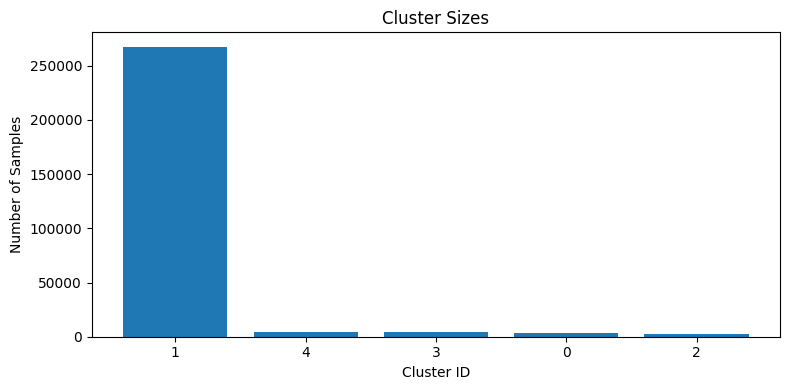

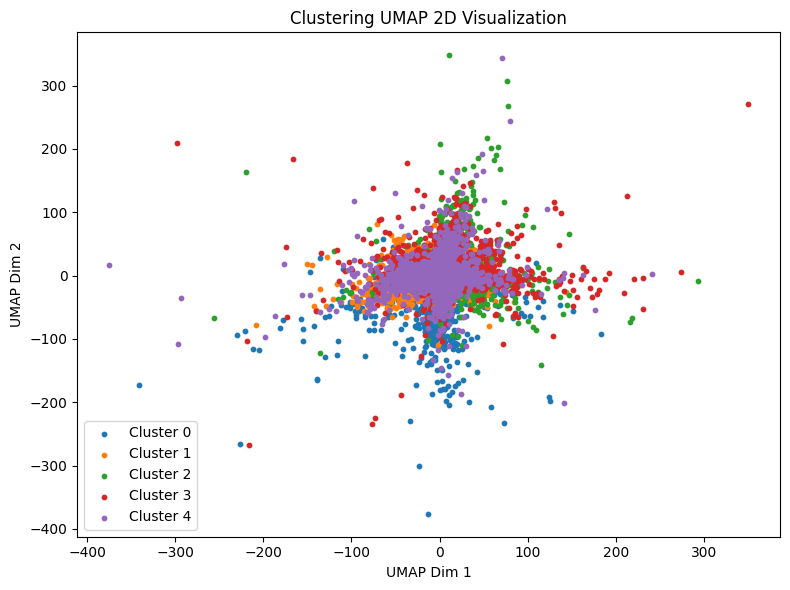

Saved clustering feature+label table to CSV.


In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# load umap and label
X_umap = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_dim10_nn5.pkl")
labels = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/kmeans_labels_dim10_nn5_k5.pkl")

# key metrics
sil = silhouette_score(X_umap, labels)
ch = calinski_harabasz_score(X_umap, labels)
db = davies_bouldin_score(X_umap, labels)

print("Clustering Internal Metrics:")
print(f"Silhouette Score:         {sil:.4f}")
print(f"Calinski-Harabasz Index:  {ch:.1f}")
print(f"Davies-Bouldin Index:     {db:.4f}")

# Count of samples in each cluster
unique, counts = np.unique(labels, return_counts=True)
cluster_stats = pd.DataFrame({"Cluster": unique, "Size": counts}).sort_values("Size", ascending=False)
print("\nCluster size statistics:\n", cluster_stats)

# Visualization: Cluster Size Bar Chart
plt.figure(figsize=(8,4))
plt.bar(cluster_stats["Cluster"].astype(str), cluster_stats["Size"])
plt.title("Cluster Sizes")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# Visualization: 2D Cluster Distribution
if X_umap.shape[1] >= 2:
    plt.figure(figsize=(8,6))
    for c in unique:
        mask = labels == c
        plt.scatter(X_umap[mask,0], X_umap[mask,1], s=10, label=f"Cluster {c}")
    plt.title("Clustering UMAP 2D Visualization")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

# save to csv
# 假设你有原始文本对应的list： texts = [...]
# 否则只保存特征和标签
df = pd.DataFrame(X_umap, columns=[f"UMAP_{i+1}" for i in range(X_umap.shape[1])])
df["cluster"] = labels
# 若有原始文本/ID可加：df["text"] = texts
df.to_csv("/content/drive/MyDrive/MSE 641 Project Data/umap_kmeans_analysis.csv", index=False)
print("Saved clustering feature+label table to CSV.")


In [ ]:
import joblib
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import cupy as cp
from cuml import UMAP, KMeans, DBSCAN

# --------- Load Data ---------
X = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/tfidf_matrix_fast.pkl")

# --------- SVD ---------
n_components = 200
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X)
row_norms = np.linalg.norm(X_svd, axis=1)
X_svd = X_svd[row_norms > 0]
X_svd, _ = np.unique(X_svd, axis=0, return_index=True)

# --------- Grid Search 参数 ---------
umap_neighbors = [5, 15, 30]
umap_dims = [10, 30]
k_range = [5, 10, 20]

best_results = {"silhouette": (-1, None, None, None), "ch": (-1, None, None, None), "db": (np.inf, None, None, None)}

for dim in umap_dims:
    for nn in umap_neighbors:
        print(f"\nTrying UMAP: dim={dim}, n_neighbors={nn}")
        X_gpu = cp.asarray(X_svd)
        umap_model = UMAP(n_components=dim, random_state=42, n_neighbors=nn, min_dist=0.1)
        X_umap_gpu = umap_model.fit_transform(X_gpu)
        X_umap = cp.asnumpy(X_umap_gpu)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X_umap_gpu).get()
            if len(np.unique(labels)) < 2: continue
            sil = silhouette_score(X_umap, labels)
            ch = calinski_harabasz_score(X_umap, labels)
            db = davies_bouldin_score(X_umap, labels)
            print(f"UMAP(dim={dim}, nn={nn}) + KMeans(k={k}): Sil={sil:.4f}  CH={ch:.1f}  DB={db:.4f}")
            if sil > best_results["silhouette"][0]:
                best_results["silhouette"] = (sil, dim, nn, k)
            if ch > best_results["ch"][0]:
                best_results["ch"] = (ch, dim, nn, k)
            if db < best_results["db"][0]:
                best_results["db"] = (db, dim, nn, k)

print("\nBest Silhouette: {:.4f} (dim={}, nn={}, k={})".format(*best_results["silhouette"]))
print("Best Calinski-Harabasz: {:.2f} (dim={}, nn={}, k={})".format(*best_results["ch"]))
print("Best Davies-Bouldin: {:.4f} (dim={}, nn={}, k={})".format(*best_results["db"]))

# --------- 重新聚类（最佳参数） ---------
best_dim, best_nn, best_k = best_results["silhouette"][1:]
X_gpu = cp.asarray(X_svd)
umap_model = UMAP(n_components=best_dim, random_state=42, n_neighbors=best_nn, min_dist=0.1)
X_umap_gpu = umap_model.fit_transform(X_gpu)
X_umap = cp.asnumpy(X_umap_gpu)
kmeans = KMeans(n_clusters=best_k, random_state=42)
best_labels = kmeans.fit_predict(X_umap_gpu).get()
joblib.dump(X_umap, f"/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_best_dim{best_dim}_nn{best_nn}.pkl")
joblib.dump(best_labels, f"/content/drive/MyDrive/MSE 641 Project Data/kmeans_labels_best_dim{best_dim}_nn{best_nn}_k{best_k}.pkl")

# --------- KMeans簇内细分：DBSCAN ---------
print("\n--- Running DBSCAN within each KMeans cluster ---")
final_labels = np.full(len(X_umap), -1)
for i in range(best_k):
    idx = (best_labels == i)
    if np.sum(idx) == 0:
        continue
    subcluster_gpu = cp.asarray(X_umap[idx])
    dbscan = DBSCAN(eps=1.2, min_samples=8)  # eps和min_samples可微调
    sub_labels_gpu = dbscan.fit_predict(subcluster_gpu)
    sub_labels = cp.asnumpy(sub_labels_gpu)
    for j, sub_label in enumerate(sub_labels):
        global_idx = np.where(idx)[0][j]
        if sub_label >= 0:
            final_labels[global_idx] = i * 100 + sub_label  # 100保证不同主簇唯一
        else:
            final_labels[global_idx] = -1  # DBSCAN噪声

joblib.dump(final_labels, f"/content/drive/MyDrive/MSE 641 Project Data/kmeans_dbscan_labels_best_dim{best_dim}_nn{best_nn}_k{best_k}.pkl")
print("All clustering results saved: UMAP, KMeans, KMeans+DBSCAN labels.")



Trying UMAP: dim=10, n_neighbors=5
[2025-07-20 23:05:31.225] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP(dim=10, nn=5) + KMeans(k=5): Sil=0.7397  CH=14359.2  DB=1.8889
UMAP(dim=10, nn=5) + KMeans(k=10): Sil=0.3569  CH=11413.3  DB=1.9177
UMAP(dim=10, nn=5) + KMeans(k=20): Sil=0.4093  CH=7916.0  DB=1.4369

Trying UMAP: dim=10, n_neighbors=15
[2025-07-20 23:52:55.677] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP(dim=10, nn=15) + KMeans(k=5): Sil=0.9061  CH=22978.5  DB=1.3974
UMAP(dim=10, nn=15) + KMeans(k=10): Sil=0.8675  CH=20684.4  DB=1.3207
UMAP(dim=10, nn=15) + KMeans(k=20): Sil=0.8250  CH=16971.9  DB=1.2203

Trying UMAP: dim=10, n_neighbors=30
[2025-07-21 00:41:39.765] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP(dim=10, nn=30) + KMeans(k=5): Sil=0.9426  CH=18368.7  DB=1.3016
UMAP(dim=10, nn=30) + KMeans(k=10): Sil=0.9316  CH=17856.7  DB=1.3092
UMAP(dim=10, nn=30) + KMe

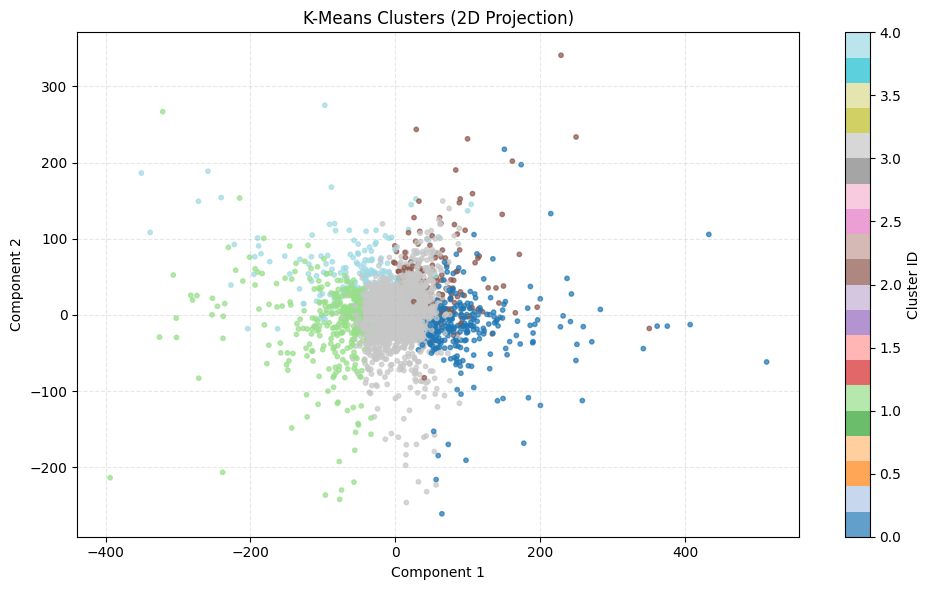

In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# --- Load UMAP features and clustering labels ---
X_umap = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/umap_matrix_best_dim10_nn30.pkl")    # (n_samples, n_umap_dims)
cluster_labels = joblib.load("/content/drive/MyDrive/MSE 641 Project Data/kmeans_labels_best_dim10_nn30_k5.pkl")  # (n_samples,)

# --- Reduce to 2D for visualization (if not already 2D) ---
if X_umap.shape[1] > 2:
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X_umap)
else:
    X_2d = X_umap

# --- Plot clusters ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=cluster_labels,
    cmap='tab20',
    s=10, alpha=0.7
)
plt.title("K-Means Clusters (2D Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()



In [ ]:
import json

# 1. Load data
file_path = "/content/drive/MyDrive/MSE 641 Project Data/wildchat_prompt_response_pairs_clean.jsonl"
texts = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line)
        if "response" in sample:
            texts.append(sample["response"])
print(f"Loaded {len(texts)} samples for clustering.")

# 2. BERT embedding
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

# 3. UMAP dimensionality reduction
import umap
umap_dim = 10
umap_model = umap.UMAP(n_components=umap_dim, n_neighbors=15, random_state=42)
X_umap = umap_model.fit_transform(embeddings)

# 4. Try different K for KMeans
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

for k in [5, 10, 20]:
    print(f"\nRunning KMeans + DBSCAN for k={k}...")

    # --- KMeans ---
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_umap)

    # --- DBSCAN within each KMeans cluster ---
    final_labels = np.full(len(X_umap), -1)
    for i in range(k):
        idx = (kmeans_labels == i)
        if np.sum(idx) == 0:
            continue
        subcluster = X_umap[idx]
        dbscan = DBSCAN(eps=1.5, min_samples=5)
        sub_labels = dbscan.fit_predict(subcluster)
        for j, sub_label in enumerate(sub_labels):
            if sub_label >= 0:
                final_labels[np.where(idx)[0][j]] = i * 1000 + sub_label
            else:
                final_labels[np.where(idx)[0][j]] = -1

    # --- 2D Visualization ---
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X_umap)
    plt.figure(figsize=(9,6))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=final_labels, cmap='tab20', s=10, alpha=0.8)
    plt.title(f"BERT + UMAP + KMeans(k={k}) + DBSCAN (2D Projection)")
    plt.xlabel("Component 1"); plt.ylabel("Component 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()



Loaded 616608 samples for clustering.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/19269 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Running KMeans + DBSCAN for k=5...


Total samples in file: 616608
Randomly sampled 20000 texts.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP finished: (20000, 10)

Running KMeans + DBSCAN for k=5...
Saved clustered results to: /content/bert_umap_kmeans5_dbscan_20k.csv


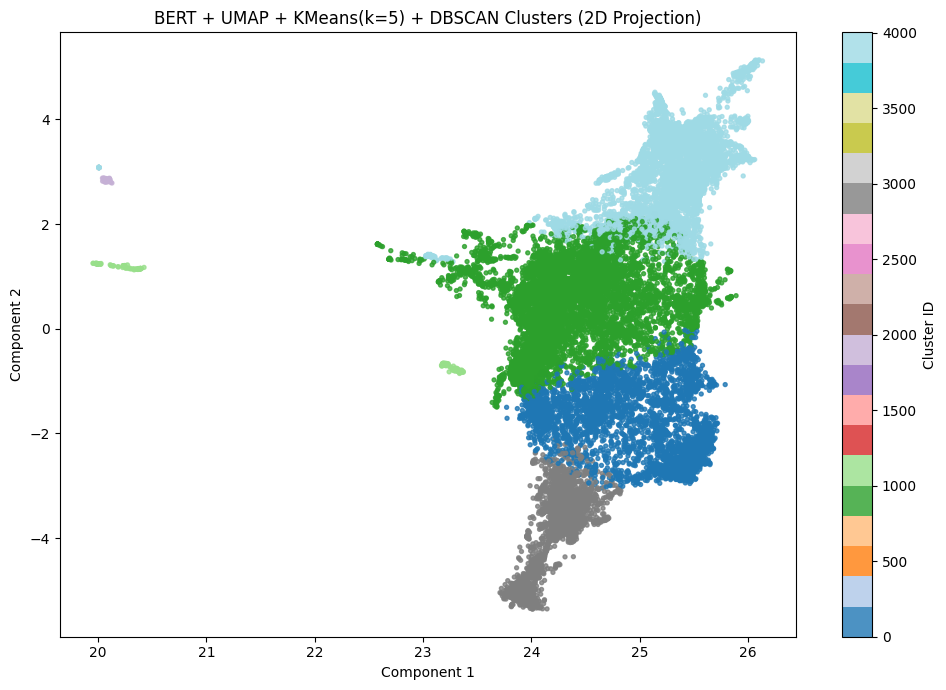


Running KMeans + DBSCAN for k=10...
Saved clustered results to: /content/bert_umap_kmeans10_dbscan_20k.csv


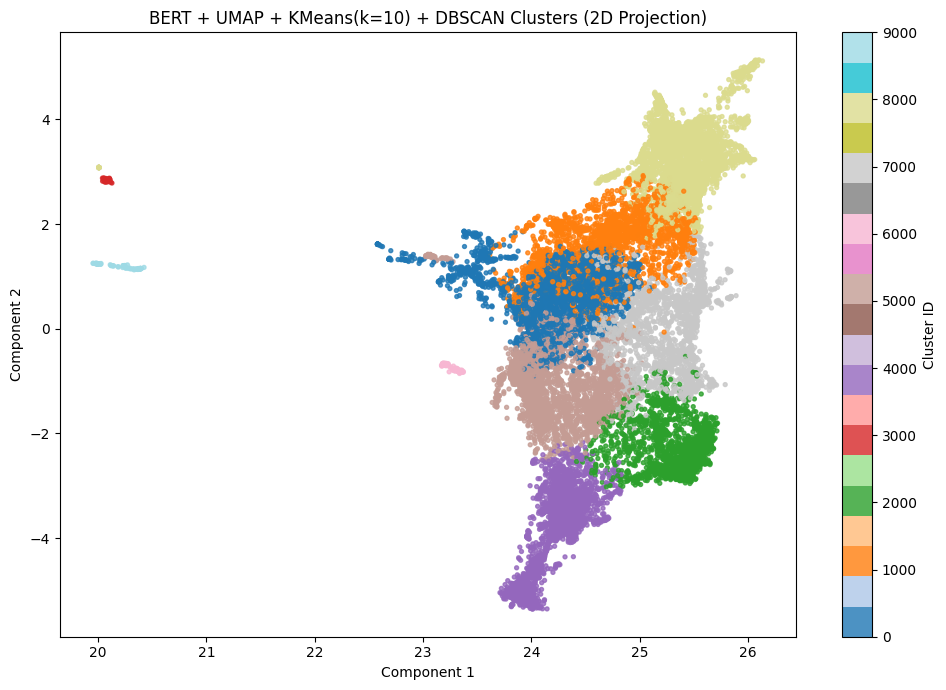


Running KMeans + DBSCAN for k=20...
Saved clustered results to: /content/bert_umap_kmeans20_dbscan_20k.csv


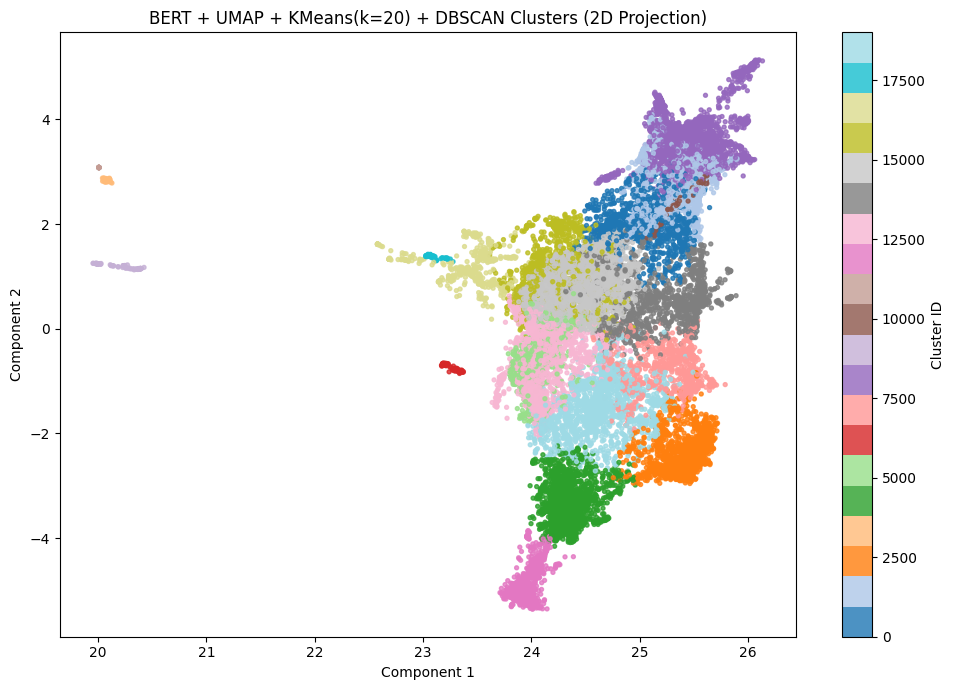

In [ ]:
# --- Step 0: Randomly Sample 20,000 Texts ---
import json, random
import numpy as np
import pandas as pd

in_path = "/content/drive/MyDrive/MSE 641 Project Data/wildchat_prompt_response_pairs_clean.jsonl"
sample_size = 20000
sampled_texts = []

# Count total lines
with open(in_path, "r", encoding="utf-8") as f:
    total_lines = sum(1 for _ in f)
print(f"Total samples in file: {total_lines}")

chosen_idxs = set(random.sample(range(total_lines), sample_size))
with open(in_path, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        if idx in chosen_idxs:
            obj = json.loads(line)
            if "response" in obj:
                sampled_texts.append(obj["response"])
        if len(sampled_texts) >= sample_size:
            break
print(f"Randomly sampled {len(sampled_texts)} texts.")

# --- Step 1: BERT Embedding ---
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sampled_texts, batch_size=64, show_progress_bar=True)

# --- Step 2: UMAP Dimensionality Reduction ---
import umap
umap_dim = 10
umap_model = umap.UMAP(n_components=umap_dim, n_neighbors=15, random_state=42)
X_umap = umap_model.fit_transform(embeddings)
print(f"UMAP finished: {X_umap.shape}")

# --- Step 3: Run KMeans+DBSCAN for k in [5,10,20] ---
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

for k in [5, 10, 20]:
    print(f"\nRunning KMeans + DBSCAN for k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_umap)

    # Per-cluster DBSCAN
    final_labels = np.full(len(X_umap), -1)
    for i in range(k):
        idx = (kmeans_labels == i)
        if np.sum(idx) == 0: continue
        subcluster = X_umap[idx]
        dbscan = DBSCAN(eps=1.5, min_samples=5)
        sub_labels = dbscan.fit_predict(subcluster)
        for j, sub_label in enumerate(sub_labels):
            if sub_label >= 0:
                final_labels[np.where(idx)[0][j]] = i * 1000 + sub_label
            else:
                final_labels[np.where(idx)[0][j]] = -1

    # --- Save results ---
    df = pd.DataFrame({
        "text": sampled_texts,
        "kmeans_label": kmeans_labels,
        "kmeans_dbscan_label": final_labels
    })
    out_csv = f"/content/bert_umap_kmeans{k}_dbscan_20k.csv"
    df.to_csv(out_csv, index=False, encoding='utf-8')
    print(f"Saved clustered results to: {out_csv}")

    # --- 2D Visualization ---
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X_umap)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=final_labels, cmap='tab20', s=8, alpha=0.8)
    plt.title(f"BERT + UMAP + KMeans(k={k}) + DBSCAN Clusters (2D Projection)")
    plt.xlabel("Component 1"); plt.ylabel("Component 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()


Total samples in file: 616608
Randomly sampled 20000 texts.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP finished: (20000, 10)

Running KMeans + DBSCAN for k=5...
  Silhouette Score:        0.3522  (higher better, max 1.0)
  Calinski-Harabasz Index: 8212.77  (higher better)
  Davies-Bouldin Index:    0.6174  (lower better, min 0)
  Saved clustered results to: /content/bert_umap_kmeans5_dbscan_20k.csv


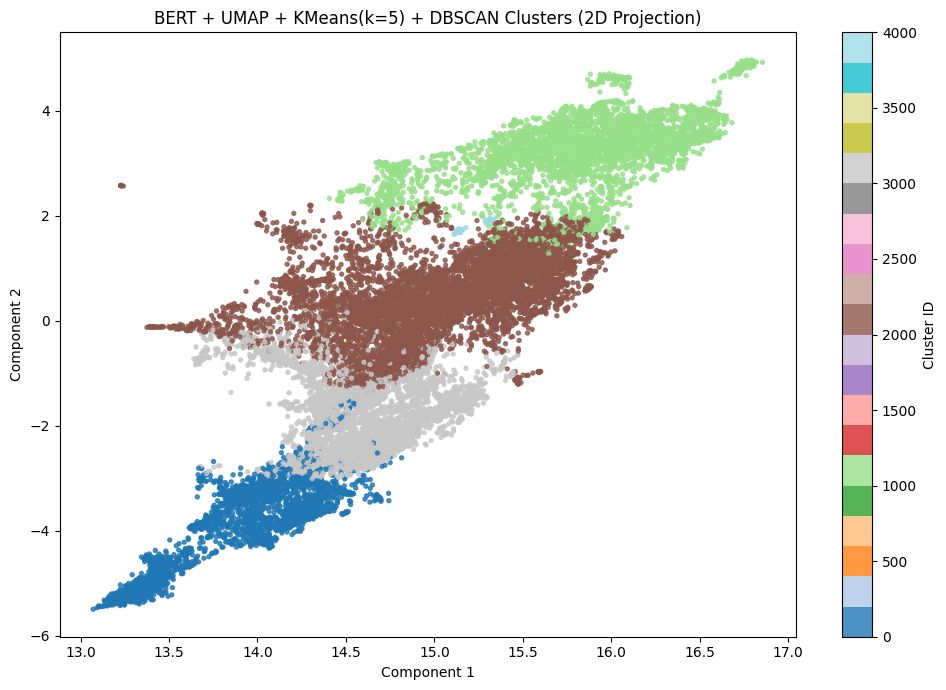


Running KMeans + DBSCAN for k=10...
  Silhouette Score:        0.3644  (higher better, max 1.0)
  Calinski-Harabasz Index: 9190.89  (higher better)
  Davies-Bouldin Index:    0.7941  (lower better, min 0)
  Saved clustered results to: /content/bert_umap_kmeans10_dbscan_20k.csv


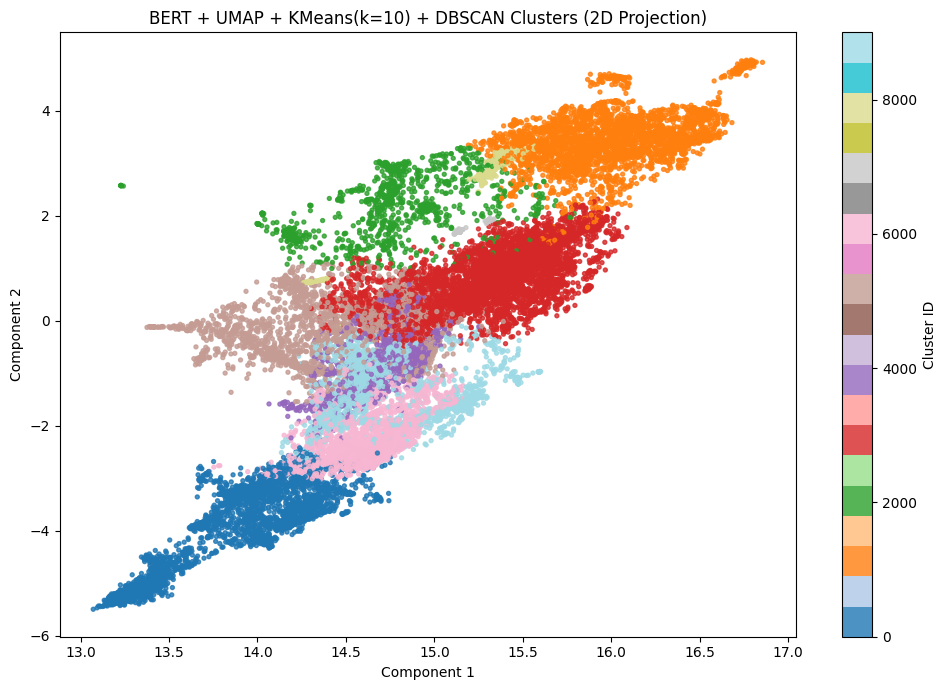


Running KMeans + DBSCAN for k=20...
  Silhouette Score:        0.3511  (higher better, max 1.0)
  Calinski-Harabasz Index: 11210.28  (higher better)
  Davies-Bouldin Index:    0.8268  (lower better, min 0)
  Saved clustered results to: /content/bert_umap_kmeans20_dbscan_20k.csv


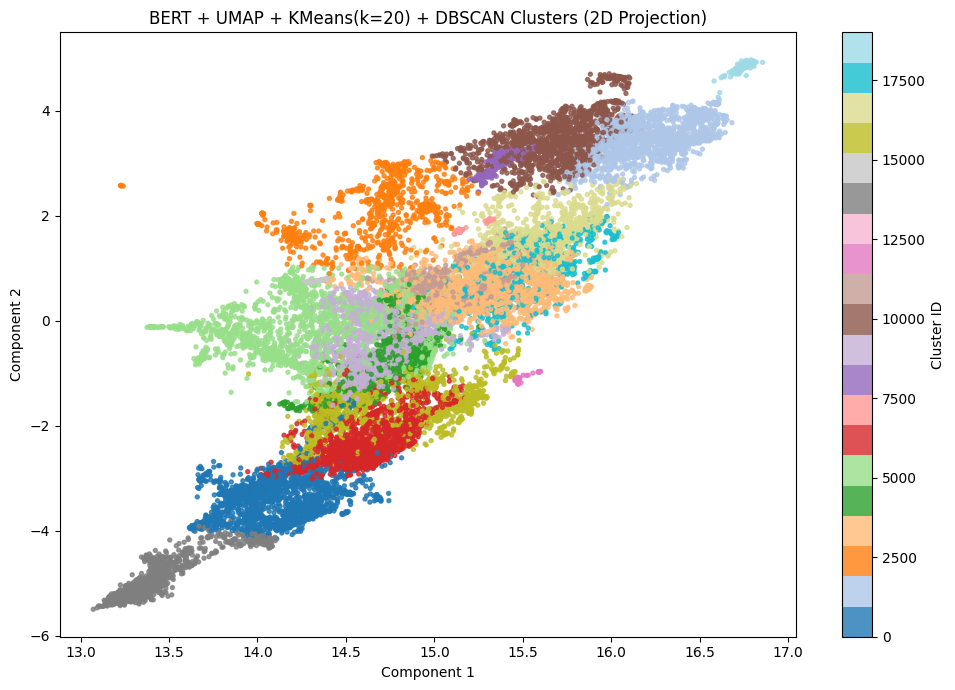

In [ ]:
# --- 0. 随机采样2万文本 ---
import json, random
import numpy as np
import pandas as pd

in_path = "/content/drive/MyDrive/MSE 641 Project Data/wildchat_prompt_response_pairs_clean.jsonl"
sample_size = 20000
sampled_texts = []

with open(in_path, "r", encoding="utf-8") as f:
    total_lines = sum(1 for _ in f)
print(f"Total samples in file: {total_lines}")

chosen_idxs = set(random.sample(range(total_lines), sample_size))
with open(in_path, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        if idx in chosen_idxs:
            obj = json.loads(line)
            if "response" in obj:
                sampled_texts.append(obj["response"])
        if len(sampled_texts) >= sample_size:
            break
print(f"Randomly sampled {len(sampled_texts)} texts.")

# --- 1. BERT嵌入 ---
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sampled_texts, batch_size=64, show_progress_bar=True)

# --- 2. UMAP降维 ---
import umap
umap_dim = 10
umap_model = umap.UMAP(n_components=umap_dim, n_neighbors=15, random_state=42)
X_umap = umap_model.fit_transform(embeddings)
print(f"UMAP finished: {X_umap.shape}")

# --- 3. KMeans+DBSCAN+指标 ---
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

for k in [5, 10, 20]:
    print(f"\nRunning KMeans + DBSCAN for k={k}...")

    # --- KMeans ---
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_umap)

    # --- DBSCAN within KMeans cluster ---
    final_labels = np.full(len(X_umap), -1)
    for i in range(k):
        idx = (kmeans_labels == i)
        if np.sum(idx) == 0: continue
        subcluster = X_umap[idx]
        dbscan = DBSCAN(eps=1.5, min_samples=5)
        sub_labels = dbscan.fit_predict(subcluster)
        for j, sub_label in enumerate(sub_labels):
            if sub_label >= 0:
                final_labels[np.where(idx)[0][j]] = i * 1000 + sub_label
            else:
                final_labels[np.where(idx)[0][j]] = -1

    # --- 指标，仅评估有效聚类样本 ---
    valid = final_labels >= 0
    X_valid = X_umap[valid]
    labels_valid = final_labels[valid]

    if len(np.unique(labels_valid)) > 1:
        sil = silhouette_score(X_valid, labels_valid)
        ch = calinski_harabasz_score(X_valid, labels_valid)
        db = davies_bouldin_score(X_valid, labels_valid)
    else:
        sil, ch, db = float('nan'), float('nan'), float('nan')
    print(f"  Silhouette Score:        {sil:.4f}  (higher better, max 1.0)")
    print(f"  Calinski-Harabasz Index: {ch:.2f}  (higher better)")
    print(f"  Davies-Bouldin Index:    {db:.4f}  (lower better, min 0)")

    # --- 保存聚类 ---
    df = pd.DataFrame({
        "text": sampled_texts,
        "kmeans_label": kmeans_labels,
        "kmeans_dbscan_label": final_labels
    })
    out_csv = f"/content/bert_umap_kmeans{k}_dbscan_20k.csv"
    df.to_csv(out_csv, index=False, encoding='utf-8')
    print(f"  Saved clustered results to: {out_csv}")

    # --- 2D 可视化 ---
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X_umap)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=final_labels, cmap='tab20', s=8, alpha=0.8)
    plt.title(f"BERT + UMAP + KMeans(k={k}) + DBSCAN Clusters (2D Projection)")
    plt.xlabel("Component 1"); plt.ylabel("Component 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()
